In [174]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report,ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# UnderSampling Techniques
from imblearn.under_sampling import RandomUnderSampler

# SMOTE Techinique
from imblearn.over_sampling import SMOTE

In [188]:
datasets=["datasets/cnn_reduced_50+pylidc_features.csv", "datasets/cnn_reduced_50+pylidc_features_nl2.csv", "datasets/pylidc_features_nl.csv"]
df=[pd.read_csv(dataset) for dataset in datasets]

In [189]:
df1=df[0]
df1.head(5)


,PatientID,Calcification,Lobulation,Spiculation,Internal Texture,Diameter (mm),Surface Area (mm^2),Volume (mm^3),Pixeis_in_lesion,Circularity,...,cnn_feature 41,cnn_feature 42,cnn_feature 43,cnn_feature 44,cnn_feature 45,cnn_feature 46,cnn_feature 47,cnn_feature 48,cnn_feature 49,Label
0,LIDC-IDRI-0001,6,3,4,5,32.755812,2491.466573,6989.673615,5428,0.121212,...,7.040247,-1.513496,0.775723,-0.234806,-5.807555,-3.458864,-4.258366,4.971976,-1.937084,5
1,LIDC-IDRI-0002,6,1,1,2,30.781671,2807.198994,7244.667508,14252,0.243756,...,3.515642,5.453791,-4.427953,-4.131188,-2.238985,-0.942886,-7.291642,7.063912,4.522726,4
2,LIDC-IDRI-0003,6,1,1,1,31.664468,1996.252117,4731.410934,2542,0.154584,...,5.648545,-5.778849,-2.962466,6.492604,-3.243713,-0.093044,-7.528972,1.491716,-5.227047,2
3,LIDC-IDRI-0003,6,2,3,4,31.001964,2225.677350,6519.463698,3241,0.139765,...,-0.395001,-0.695193,-0.807704,1.977416,-2.345557,-1.399320,-3.947806,9.112702,-2.307368,4
4,LIDC-IDRI-0003,6,2,2,5,13.309155,321.183599,472.089669,261,0.271896,...,-1.828549,-1.749191,-3.188446,-0.763180,0.101668,-0.589906,1.837360,-0.556560,-2.447910,3


In [190]:
#to keep the nodules from the same patient in the same group either train or test, we do this:
from sklearn.model_selection import GroupShuffleSplit 

splitter = GroupShuffleSplit(test_size=0.2, n_splits=2, random_state = 42)
split = splitter.split(df1, groups=df1['PatientID'])
train_inds, test_inds = next(split)

train = df1.iloc[train_inds]
test = df1.iloc[test_inds]

In [191]:
#seperate the class from the features and drop index
testy=test["Label"]
testx=test.drop(["Label","PatientID"],axis=1)
testx=testx.reset_index(drop=True)
trainy=train["Label"]
trainx=train.drop(["Label","PatientID"],axis=1)
trainx=trainx.reset_index(drop=True)

In [ ]:
# IMPORTANT: ONLY RUN THIS PART OF THE CODE IF YOU WANT UNDERSAMPLING IN YOUR TRAINNIG DATA
#
print("Original class distribution:\n",trainy.value_counts())

undersample= RandomUnderSampler(random_state=42)
trainx,trainy= undersample.fit_resample(trainx,trainy)

print("\nUnderSamlped class distribuition:\n",trainy.value_counts())

Original class distribution:
 Label
3    831
2    646
4    357
1    225
5     52
Name: count, dtype: int64

UnderSamlped class distribuition:
 Label
1    52
2    52
3    52
4    52
5    52
Name: count, dtype: int64


In [192]:
# IMPORTANT ONLY RUN THIS PART OF THE CODE IF YOU WANT SMOTE IN YOUR TRAINNING DATA
#
print("Original class distribution:\n",trainy.value_counts())

smote=SMOTE(random_state=42)
trainx, trainy=smote.fit_resample(trainx,trainy)

print("\nSMOTE class distribution:",trainy.value_counts())

Original class distribution:
 Label
3    831
2    646
4    357
1    225
5     52
Name: count, dtype: int64

SMOTE class distribution: Label
5    831
4    831
2    831
3    831
1    831
Name: count, dtype: int64


In [193]:
trainy.head(5)

0    5
1    4
2    2
3    4
4    3
Name: Label, dtype: int64

In [194]:
#Using CV to tune the parameters but with the n_estimators fixed at 1000

param_dist = {'max_depth': randint(5,50),
              'min_samples_split': randint(2,10)}

rf = RandomForestClassifier(n_estimators=1000,random_state=42)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=50, 
                                 cv=5,
                                 n_jobs=-1,
                                 random_state=42)

# Fit the random search object to the data
rand_search.fit(trainx, trainy)
print("Best parameters:", rand_search.best_params_)
print("Best cross_validation_score:", rand_search.best_score_)

Best parameters: {'max_depth': 48, 'min_samples_split': 2}
Best cross_validation_score: 0.7814681107099879


In [195]:
rft = RandomForestClassifier(n_estimators=1000, max_depth=48, min_samples_split=3,random_state=42) 
rft.fit(trainx, trainy)

RandomForestClassifier(max_depth=48, min_samples_split=3, n_estimators=1000,
                       random_state=42)

In [196]:
#Get the features names
feature_names = [col for col in df1.columns if col not in ["Label", "PatientID"]]

#Gives us the most important attributes to the RandomForest classifier
feature_importances = rft.feature_importances_

# Combine feature names with their importance values
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance (descending)
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

importance_df.head(51)


,Feature,Importance
0,Calcification,0.064908
1,Surface Area (mm^2),0.053767
2,Diameter (mm),0.053419
3,Volume (mm^3),0.051629
4,Pixeis_in_lesion,0.050660
5,STD_HU_in_lesion,0.042736
6,VAR_HU_in_lession,0.038609
7,Mean_HU_in_lesion,0.030231
8,Circularity,0.029125
9,Median_HU_in_lesion,0.023869


In [197]:
predy=rft.predict(testx)
print(accuracy_score(testy,predy))
print(recall_score(testy,predy,average="macro"))
print(precision_score(testy,predy,average="weighted"))
print(classification_report(testy,predy))

0.5291828793774319
0.5812152554114369
0.5348135307554968
              precision    recall  f1-score   support

           1       0.86      0.79      0.82        61
           2       0.52      0.43      0.47       184
           3       0.46      0.48      0.47       187
           4       0.49      0.70      0.58        64
           5       0.56      0.50      0.53        18

    accuracy                           0.53       514
   macro avg       0.58      0.58      0.57       514
weighted avg       0.53      0.53      0.53       514



In [198]:
np.unique(trainy)
#1 significa benigno, 3 incerto, 5 maligno

array([1, 2, 3, 4, 5])

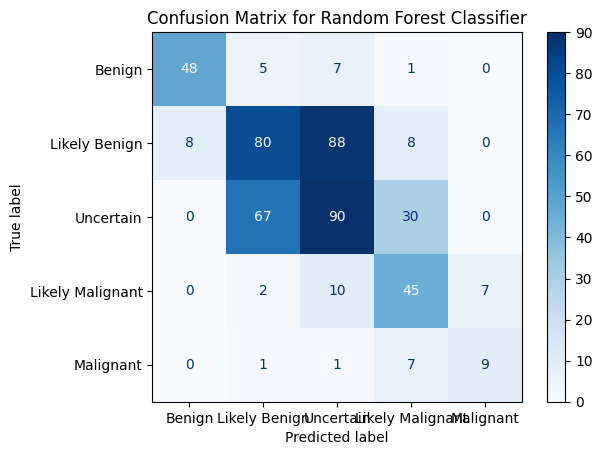

In [201]:
import matplotlib.pyplot as plt
cm = confusion_matrix(testy, predy)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign","Likely Benign","Uncertain","Likely Malignant","Malignant"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

In [84]:
df2=df[0]
df3=df[1]
new_dataset="datasets/pylidc_features_nl.csv"
df4=pd.read_csv(new_dataset)

In [85]:
splitter = GroupShuffleSplit(test_size=0.2, n_splits=2, random_state = 42)
split = splitter.split(df4, groups=df4['PatientID'])
train_inds, test_inds = next(split)
train = df4.iloc[train_inds]
test = df4.iloc[test_inds]

In [86]:
testy2=test["Label"]
testx2=test.drop(["Label","PatientID"],axis=1)
testx2=testx2.reset_index(drop=True)
trainy2=train["Label"]
trainx2=train.drop(["Label","PatientID"],axis=1)
trainx2=trainx2.reset_index(drop=True)

In [87]:
trainy2.head(5)

0    5
1    5
2    1
3    5
4    3
Name: Label, dtype: int64

In [88]:
rft2 = RandomForestClassifier(n_estimators=1000, max_depth=12, min_samples_split=8,random_state=42) 
rft2.fit(trainx2, trainy2)

RandomForestClassifier(max_depth=12, min_samples_split=8, n_estimators=1000,
                       random_state=42)

In [89]:
predy2=rft2.predict(testx2)
print(classification_report(testy2,predy2))
60
59
62
63

              precision    recall  f1-score   support

           1       0.70      0.56      0.63       245
           3       0.49      0.61      0.55       187
           5       0.75      0.76      0.75        82

    accuracy                           0.61       514
   macro avg       0.65      0.64      0.64       514
weighted avg       0.63      0.61      0.62       514



63

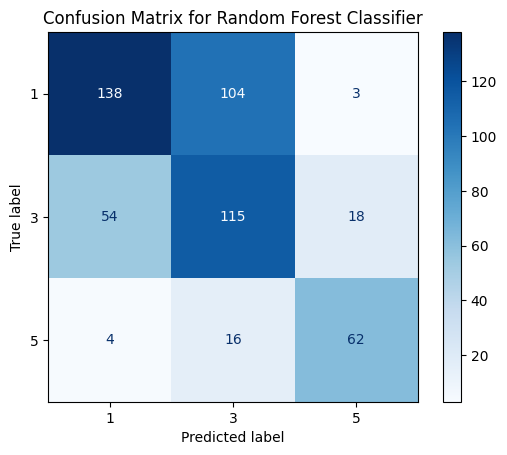

In [90]:
cm = confusion_matrix(testy2, predy2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["1","3","5"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()